# Modelo de DEEP LEARNING baseado na memória de curto prazo - LSTM

## 1. Bibliotecas

In [35]:
import math
import numpy                  as np
import pandas                 as pd
import yfinance               as yf

import matplotlib.pyplot      as plt

from datetime                 import datetime
from datetime                 import timedelta

from sklearn.preprocessing    import MinMaxScaler

from keras.models             import Sequential
from keras.layers             import Dense, LSTM

## 2. Ativo de interesse

In [3]:
acao = 'MGLU3.SA'

inicio = '2014-12-31'
final  = '2023-05-26'

dados_acao = yf.download(acao, inicio, final)

dados_acao

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,0.243750,0.243750,0.231562,0.232812,0.215259,6323200
2015-01-05,0.235625,0.240625,0.229687,0.237187,0.219304,10326400
2015-01-06,0.238437,0.238437,0.233125,0.234062,0.216414,12572800
2015-01-07,0.237500,0.242187,0.234687,0.241875,0.223638,6454400
2015-01-08,0.239375,0.242187,0.237500,0.240000,0.221905,8393600
...,...,...,...,...,...,...
2023-05-19,3.580000,3.730000,3.530000,3.640000,3.640000,146332000
2023-05-22,3.670000,3.870000,3.660000,3.800000,3.800000,126815600
2023-05-23,3.830000,3.840000,3.640000,3.660000,3.660000,114830900


In [4]:
# Selecionaremos o valor de fechamento 'Close', ao invés da cotação ajustada 'Adj Close' (mais comunmente encontrada
# nos modelos de financças), pois precisamos de uma cotação real;

cotacao = dados_acao['Close'].to_numpy().reshape(-1, 1) # reescalando os dados com o numpy
cotacao

array([[0.232812  ],
       [0.237187  ],
       [0.234062  ],
       ...,
       [3.66000009],
       [3.63000011],
       [3.75999999]])

In [5]:
tamanho_dados_treinamento = int(len(cotacao) * 0.8)

tamanho_dados_treinamento

1669

## 3. Separando os dados em treino e teste

In [6]:
# Escalar os dados entre 0 e 1

escalador = MinMaxScaler(feature_range=(0, 1))

dados_entre_0_e_1_treinamento = escalador.fit_transform(cotacao[0:tamanho_dados_treinamento, :])

dados_entre_0_e_1_teste = escalador.transform(cotacao[tamanho_dados_treinamento: , :])

dados_entre_0_e_1 = list(dados_entre_0_e_1_treinamento.reshape(
    len(dados_entre_0_e_1_treinamento))) + list(dados_entre_0_e_1_teste.reshape(len(dados_entre_0_e_1_teste)))

dados_entre_0_e_1 = np.array(dados_entre_0_e_1).reshape(len(dados_entre_0_e_1), 1)

dados_entre_0_e_1

array([[0.00737532],
       [0.00753488],
       [0.00742091],
       ...,
       [0.13236661],
       [0.13127249],
       [0.13601366]])

In [7]:
dados_para_treinamento = dados_entre_0_e_1[0: tamanho_dados_treinamento, :]

# dados usados para gerar o resultado
treinamento_x = []

# cotação real
treinamento_y = []

for i in range(60, len(dados_para_treinamento)):
    
    # 60 últimos dias
    treinamento_x.append(dados_para_treinamento[i - 60: i, 0])
    
    # cotação real
    treinamento_y.append(dados_para_treinamento[i, 0])
    
    if i <= 61:
        print(treinamento_x)
        print(treinamento_y)


[array([0.00737532, 0.00753488, 0.00742091, 0.00770585, 0.00763747,
       0.00734115, 0.00743232, 0.00734115, 0.00720438, 0.00718159,
       0.00724997, 0.00720438, 0.00686247, 0.00691944, 0.00688527,
       0.00691944, 0.00686247, 0.00663453, 0.00641797, 0.0066915 ,
       0.00663453, 0.00668012, 0.006361  , 0.00628121, 0.00617865,
       0.00582532, 0.00575694, 0.00588233, 0.00549483, 0.0056088 ,
       0.00582532, 0.00585953, 0.00613306, 0.00612165, 0.00620145,
       0.00640659, 0.00622424, 0.0063838 , 0.00577974, 0.00581395,
       0.00558601, 0.00520988, 0.0051415 , 0.00495915, 0.00466283,
       0.00491356, 0.00486797, 0.00515292, 0.00487939, 0.00469704,
       0.00462865, 0.00457165, 0.00468562, 0.00470842, 0.00470842,
       0.00466283, 0.00458307, 0.00456027, 0.00452606, 0.00462865])]
[0.004685621274704243]
[array([0.00737532, 0.00753488, 0.00742091, 0.00770585, 0.00763747,
       0.00734115, 0.00743232, 0.00734115, 0.00720438, 0.00718159,
       0.00724997, 0.00720438, 0.00

In [8]:
# Transformando as listas em arrays e dando um reshape, pois o modelo necessida dos dados em 3 Dimensões

treinamento_x, treinamento_y = np.array(treinamento_x), np.array(treinamento_y)
treinamento_x = treinamento_x.reshape(treinamento_x.shape[0], treinamento_x.shape[1], 1)
treinamento_x

array([[[0.00737532],
        [0.00753488],
        [0.00742091],
        ...,
        [0.00456027],
        [0.00452606],
        [0.00462865]],

       [[0.00753488],
        [0.00742091],
        [0.00770585],
        ...,
        [0.00452606],
        [0.00462865],
        [0.00468562]],

       [[0.00742091],
        [0.00770585],
        [0.00763747],
        ...,
        [0.00462865],
        [0.00468562],
        [0.00485659]],

       ...,

       [[0.76367106],
        [0.74944758],
        [0.78847102],
        ...,
        [0.63493021],
        [0.61997731],
        [0.60502441]],

       [[0.74944758],
        [0.78847102],
        [0.77898868],
        ...,
        [0.61997731],
        [0.60502441],
        [0.59590678]],

       [[0.78847102],
        [0.77898868],
        [0.78409459],
        ...,
        [0.60502441],
        [0.59590678],
        [0.60320084]]])

## 4.0 Modelo

In [9]:
modelo = Sequential()

# Modelo com 50 neurônios;
# return sequences = True pois usaremos outro LSTM depois;
# definir o shape, que no caso são 60 informações para gerar um valor;
# adicionar mais neurônios com o dense de 25 e 1

modelo.add(LSTM(50, return_sequences=True, input_shape = (treinamento_x.shape[1], 1))) # Modelo de 50 neurônios + return_sequences = True para adicionar mais 50 neurônios
modelo.add(LSTM(50, return_sequences=False))
modelo.add(Dense(25))
modelo.add(Dense(1))

treinamento_x.shape[1]

60

In [10]:
# Copilando o modelo

# A função de Loss é a forma de medir o ERRO do modelo, que nesse caso é classificado como o Erro Médio Quadrátrico que é
# usado na Regresão Linear

modelo.compile(optimizer = 'adam', loss='mean_squared_error')

In [11]:
# Agora com o modelo copilado e os dados, treinaremos o modelo
# batch size -> neste caso o modelo irá otimizar os parâmetros a cada novo dado
# epochs -> quantas vezes o algoritmo irá rodar os dados de treinamento

modelo.fit(treinamento_x, treinamento_y, batch_size=1, epochs=1)

1609/1609 [==============================] - 57s 32ms/step - loss: 0.0021


### 4.1 Modelo de teste

In [12]:
dados_teste = dados_entre_0_e_1[tamanho_dados_treinamento - 60:, :]

teste_x = []
teste_y = cotacao[tamanho_dados_treinamento: , :]

for i in range(60, len(dados_teste)):
    teste_x.append(dados_teste[i - 60: i, 0])

In [13]:
# reshape

teste_x = np.array(teste_x)
teste_x = teste_x.reshape(teste_x.shape[0], teste_x.shape[1], 1)

### 4.2 Predições do Modelo

In [14]:
predicoes = modelo.predict(teste_x)

# Tirando a escala dos dados
predicoes = escalador.inverse_transform(predicoes)

predicoes

14/14 [==============================] - 2s 32ms/step


array([[15.966839 ],
       [15.767241 ],
       [15.612723 ],
       [15.457038 ],
       [15.29582  ],
       [15.091599 ],
       [14.809558 ],
       [14.490469 ],
       [14.216079 ],
       [14.010469 ],
       [13.7885   ],
       [13.5782795],
       [13.4638   ],
       [13.374523 ],
       [13.393841 ],
       [13.418391 ],
       [13.456301 ],
       [13.467851 ],
       [13.498429 ],
       [13.510307 ],
       [13.461694 ],
       [13.3428   ],
       [13.11865  ],
       [12.857527 ],
       [12.5916195],
       [12.316035 ],
       [12.027975 ],
       [11.720705 ],
       [11.401845 ],
       [11.149356 ],
       [10.979539 ],
       [10.832135 ],
       [10.832211 ],
       [10.870554 ],
       [11.035067 ],
       [11.245528 ],
       [11.5193405],
       [11.581075 ],
       [11.394604 ],
       [11.041716 ],
       [10.599966 ],
       [10.1714   ],
       [ 9.751745 ],
       [ 9.356043 ],
       [ 9.029927 ],
       [ 8.763619 ],
       [ 8.501825 ],
       [ 8.26

### 4.3 Erro Médio Quadrático

In [15]:
rmse = np.sqrt(np.mean(predicoes - teste_y) ** 2)
rmse

0.277630033105184

In [16]:
# Criando o gráfico do modelo

treinamento = dados_acao.iloc[:tamanho_dados_treinamento, :]
df_teste = pd.DataFrame({'Close': dados_acao['Close'].iloc[tamanho_dados_treinamento:],
                        'predicoes': predicoes.reshape(len(predicoes))})

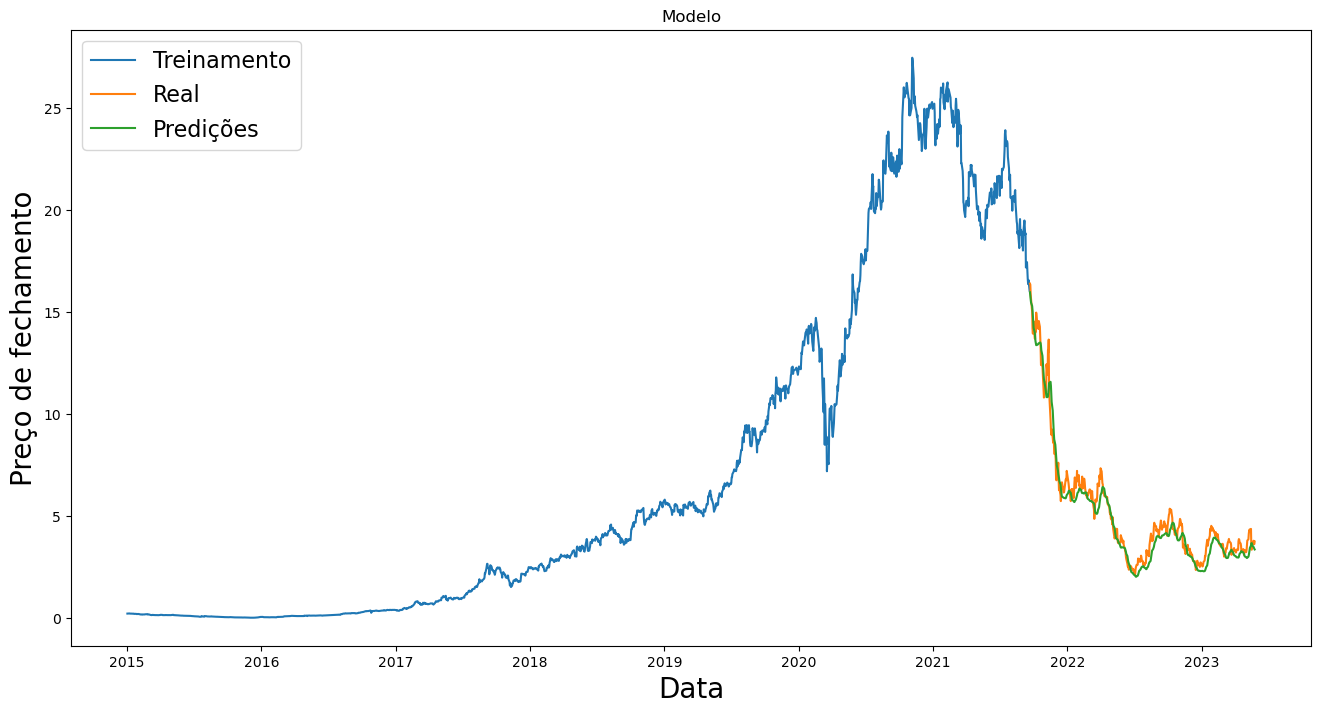

In [18]:
# Gerando o gráfico

plt.figure(figsize = (16, 8))
plt.title('Modelo')
plt.xlabel('Data', fontsize = 20)
plt.ylabel('Preço de fechamento', fontsize = 20)
plt.plot(treinamento['Close'])
plt.plot(df_teste[['Close', 'predicoes']])
plt.legend(['Treinamento', 'Real', 'Predições'], loc = 2, prop={'size': '16'})
plt.show()

In [19]:
df_teste.sort_index()

df_teste

,Close,predicoes
Date,,
2021-09-21,16.389999,15.966839
2021-09-22,16.340000,15.767241
2021-09-23,15.870000,15.612723
2021-09-24,15.630000,15.457038
2021-09-27,15.010000,15.295820
...,...,...
2023-05-19,3.640000,3.560887
2023-05-22,3.800000,3.493733
2023-05-23,3.660000,3.448346


### 4.4 Avaliando a acertividade do modelo em prever o direcionamento do ativo

In [24]:
df_teste['variacao_percentual_acao'] = df_teste['Close'].pct_change()
df_teste['variacao_percentual_modelo'] = df_teste['predicoes'].pct_change()

df_teste = df_teste.dropna()

df_teste['var_acao_maior_menor_que_zero'] = np.where(df_teste['variacao_percentual_acao'] > 0, True, False)
df_teste['var_modelo_maior_menor_que_zero'] = np.where(df_teste['variacao_percentual_modelo'] > 0, True, False)

df_teste['acertou_o_lado'] = np.where(df_teste['var_acao_maior_menor_que_zero'] == df_teste['var_modelo_maior_menor_que_zero'], True, False)
df_teste['variacao_percentual_acao_abs'] = df_teste['variacao_percentual_acao'].abs()
df_teste

C:\Users\d311r.DESKTOP-O2NL7MH\AppData\Local\Temp\ipykernel_8612\2237842766.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste['variacao_percentual_acao'] = df_teste['Close'].pct_change()
C:\Users\d311r.DESKTOP-O2NL7MH\AppData\Local\Temp\ipykernel_8612\2237842766.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste['variacao_percentual_modelo'] = df_teste['predicoes'].pct_change()
C:\Users\d311r.DESKTOP-O2NL7MH\AppData\Local\Temp\ipykernel_8612\2237842766.py:6: SettingWithCopyWarning: 
A v

,Close,predicoes,variacao_percentual_da_acao,variacao_percentual_do_modelo,var_acao_maior_menor_que_zero,var_modelo_maior_menor_que_zero,acertou_o_lado,variacao_percentual_acao,variacao_percentual_modelo,variacao_percentual_acao_abs
Date,,,,,,,,,,
2021-09-23,15.87,15.612723,-0.028764,-0.009800,False,False,True,-0.028764,-0.009800,0.028764
2021-09-24,15.63,15.457038,-0.015123,-0.009972,False,False,True,-0.015123,-0.009972,0.015123
2021-09-27,15.01,15.295820,-0.039667,-0.010430,False,False,True,-0.039667,-0.010430,0.039667
2021-09-28,14.18,15.091599,-0.055296,-0.013351,False,False,True,-0.055296,-0.013351,0.055296
2021-09-29,13.94,14.809558,-0.016925,-0.018689,False,False,True,-0.016925,-0.018689,0.016925
...,...,...,...,...,...,...,...,...,...,...
2023-05-19,3.64,3.560887,0.028249,-0.019576,True,False,False,0.028249,-0.019576,0.028249
2023-05-22,3.80,3.493733,0.043956,-0.018859,True,False,False,0.043956,-0.018859,0.043956
2023-05-23,3.66,3.448346,-0.036842,-0.012991,False,False,True,-0.036842,-0.012991,0.036842


In [33]:
acertou_lado = df_teste['acertou_o_lado'].sum()/len(df_teste['acertou_o_lado'])
errou_lado = 1 - acertou_lado

media_lucro = df_teste.groupby('acertou_o_lado')['variacao_percentual_acao_abs'].mean()

exp_mat_lucro = acertou_lado * media_lucro[1] - media_lucro[0] * errou_lado

ganho_sobre_perda = media_lucro[1]/media_lucro[0]

print(f'O lucro médio foi de \n{media_lucro.round(4)}')
print(f'A relação de Lucro/Perda foi de {ganho_sobre_perda.round(4)}')
print(f'O percentual de acerto do lado foi de {acertou_lado.round(4)*100}%')
print(f'Expectativa de ganho por dia {exp_mat_lucro.round(4)*100}%')

O lucro médio foi de 
acertou_o_lado
False    0.0405
True     0.0403
Name: variacao_percentual_acao_abs, dtype: float64
A relação de Lucro/Perda foi de 0.9945
O percentual de acerto do lado foi de 51.2%
Expectativa de ganho por dia 0.09%


### 4.5 Gerando previsão de direção do ativo

In [41]:
data_hoje = datetime.now()

if data_hoje.hour > 18: # verificando se o mercado está aberto ou já fechou
    final = data_hoje
    inicial = datetime.now() - timedelta(days = 252)
    
else:
    final = data_hoje - timedelta(days = 1)
    inicial = datetime.now() - timedelta(days = 252)


cotacoes = yf.download(acao, inicial, final)
ultimos_60_dias = cotacoes['Close'].iloc[-60:].values.reshape(-1, 1)

ultimos_60_dias_escalado = escalador.transform(ultimos_60_dias)

teste_x = []
teste_x.append(ultimos_60_dias_escalado)
teste_x = np.array(teste_x)
teste_x = teste_x.reshape(teste_x.shape[0], teste_x.shape[1], 1)

previsao_de_preco = modelo.predict(teste_x)
previsao_de_preco = escalador.inverse_transform(previsao_de_preco)

print(previsao_de_preco)

[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 68ms/step
[[3.355341]]
